# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [1]:
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Resize, Normalize

import multiprocessing

num_cores = multiprocessing.cpu_count()
import tests

In [2]:
import random
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True

In [3]:
data_dir = 'data/processed-celeba-small/celeba'

In [4]:
for im in os.listdir(data_dir):
    if not im.endswith('.jpg'):
        print(im)

New Folder With Items


## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [5]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    # TODO: edit this function by appening transforms to the below list
    CHANNELS_IMG = 3
    transforms = [
            Resize(size),
            ToTensor(),
            Normalize(
                [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
            ),
        ]
    
    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [6]:
from torchvision.io import read_image
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '.jpg'):
        # TODO: implement the init method
        super().__init__()
        self.directory = directory
        self.transforms = transforms
        self.extension = extension
        self.file_list = [file for file in os.listdir(self.directory) if file.endswith(self.extension)]

    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        # TODO: return the number of elements in the dataset
        return len(self.file_list)

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        # TODO: return the index-element of the dataset
        image_path = os.path.join(self.directory, self.file_list[index])
        image = Image.open(image_path)

        if self.transforms:
            image = self.transforms(image)
        return image

In [7]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

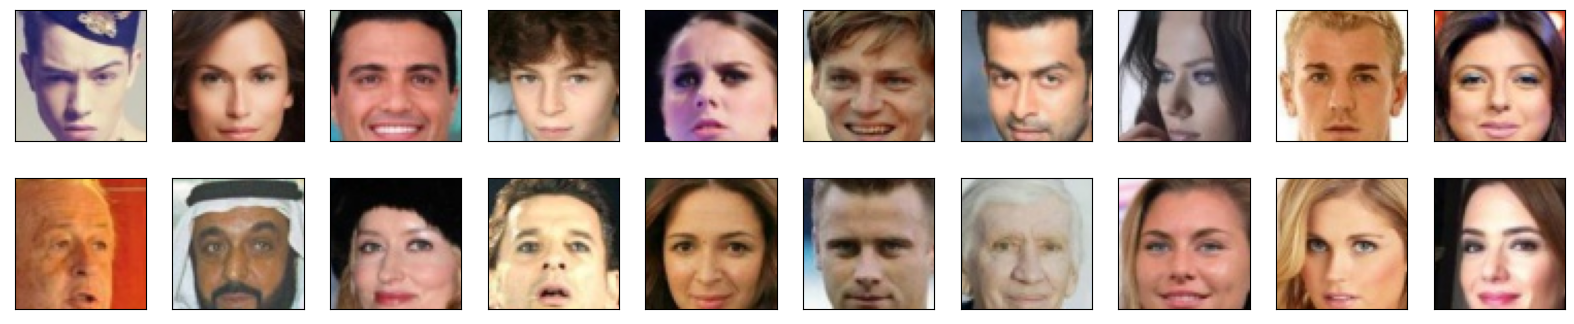

In [8]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def revert_img(img):
    """
    Revert image from [-1.0, 1.0] to [0.0, 1.0]
    """
    return (img*0.5)+0.5

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [9]:
tests.image_size_conv_output(64, padding=[1,1,1,1,0], kernel = 4, stride=2, layers = 5)

layer_1: 32
layer_2: 16
layer_3: 8
layer_4: 4
layer_5: 1


In [10]:
import torch.nn as nn

In [11]:
class Discriminator(nn.Module):
    """
    The discriminator model adapted from the DCGAN paper. It should only contains a few layers.
    args:
    - conv_dim: control the number of filters
    """
    def __init__(self, conv_dim: int = 64, channels_img: int = 3):
        super().__init__()
        self.conv_dim = conv_dim
        self.conv1 = self._block(in_channels=channels_img, out_channels=conv_dim, kernel_size=4, bias=True, batch_norm = False) # 64x64 -> 32x32
        self.conv2 = self._block(in_channels=conv_dim, out_channels=conv_dim*2, kernel_size=4, bias=False) # 32x32 -> 16x16
        self.conv3 = self._block(in_channels=conv_dim*2, out_channels=conv_dim*4, kernel_size=4, bias=False) # 16x16 -> 8x8
        self.conv4 = self._block(in_channels=conv_dim*4, out_channels=conv_dim*8, kernel_size=4, bias=False) # 8x8 -> 4x4
        self.conv5 = nn.Conv2d(conv_dim*8, 1, kernel_size=4, stride=2, padding=0, bias=False) # 4x4 -> 1x1
        # self.conv4 = self._block(in_channels=conv_dim*4, out_channels=conv_dim*4*4, kernel_size=4, padding=0, bias=False) # 4x4 -> 1x1
        
        # get rid of any fully connected layer with respect to the DCGAN paper
        # self.flatten = nn.Flatten()
        # self.fc1 = nn.Linear((conv_dim*4*4), conv_dim*4)
        # self.fc2 = nn.Linear((conv_dim*4), 1)
        
    def _block(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: int, 
                 stride: int = 2, 
                 padding: int = 1,
                 bias: bool = False,
                 batch_norm: bool = True):
        if batch_norm:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias),
                nn.InstanceNorm2d(out_channels, affine=True), # also you can use LayerNorm
                nn.LeakyReLU(0.2)
            )
        else:
            return nn.Sequential(
                # in the DCGAN paper, they say not to use batchnorm on the first layer of descriminator and last layer of generator
                # however, in dicriminator, the bias will be canceled out in the following layers I think! so in the end, we don't have any bias!?
                nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias),
                nn.LeakyReLU(0.2)
            )
    def forward(self, x):  
        x = self.conv1(x)
        # print(f"shape at conv1: {x.shape}")
        x = self.conv2(x)
        # print(f"shape at conv2: {x.shape}")
        x = self.conv3(x)
        # print(f"shape at conv3: {x.shape}")
        x = self.conv4(x)
        # print(f"shape at conv4: {x.shape}")
        x = self.conv5(x)
        # print(f"shape at conv5: {x.shape}")
        # x = self.flatten(x)
        # print(f"shape at flatten: {x.shape}")
        # x = self.fc1(x)
        # x = self.fc2(x)
        # print(f"Discriminator fc2: {x.shape}")
        # x = x.squeeze()
        # print(x)
        return x

In [12]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [13]:
tests.image_size_trans_conv_output(1, padding=[0,1,1,1,1], kernel = 4, stride=2, layers = 5)

layer_1: 4
layer_2: 8
layer_3: 16
layer_4: 32
layer_5: 64


In [14]:
class Generator(nn.Module):
    """
    The generator model adapted from DCGAN
    args:
    - latent_dim: dimension of the latent vector 100x1x1
    - conv_dim: control the number of filters in the convtranspose layers
    """
    def __init__(self, latent_dim: int, conv_dim: int = 64, channels_img: int = 3):
        super().__init__()
        
        self.conv_dim = conv_dim
        # self.flatten = nn.Flatten()
        # self.fc1 = nn.Linear(latent_dim, conv_dim*4*4, bias=False)
        # reshape to (batch_size, conv_dim, 4, 4)
        # self.tconv1 = self._block(in_channels=conv_dim*4*4, out_channels=conv_dim*4, kernel_size=4, stride=2, padding=0, bias=False)
        self.tconv1 = self._block(in_channels=latent_dim, out_channels=conv_dim*8, kernel_size=4, stride=2, padding=0, bias=False)
        self.tconv2 = self._block(in_channels=conv_dim*8, out_channels=conv_dim*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.tconv3 = self._block(in_channels=conv_dim*4, out_channels=conv_dim*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.tconv4 = self._block(in_channels=conv_dim*2, out_channels=conv_dim, kernel_size=4, stride=2, padding=1, bias=False)
        self.tconv5 = self._block(in_channels=conv_dim, out_channels=channels_img, kernel_size=4, stride=2, padding=1, bias=True, batch_norm=False)
    
    
    
    def _block(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: int, 
                 stride: int,
                 padding: int,
                 bias: bool = False,
                 batch_norm: bool = True):
        """
        A "de-convolutional" block is made of 3 layers: ConvTranspose -> BatchNorm -> Activation.
        args:
        - in_channels: number of channels in the input to the conv layer
        - out_channels: number of filters in the conv layer
        - kernel_size: filter dimension of the conv layer
        - stride: stride of the conv layer
        - padding: padding of the conv layer
        - batch_norm: whether to use batch norm or not
        """
        if batch_norm:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias),
                nn.Tanh(),
            )
            
    def forward(self, x):
        # x = self.flatten(x)
        # x = self.fc1(x)
        # x = x.view(-1, self.conv_dim*4*4, 1, 1)
        # print(f"input {x.shape}")
        x = self.tconv1(x)
        # print(f"shape at conv1: {x.shape}")
        x = self.tconv2(x)
        # print(f"shape at conv2: {x.shape}")
        x = self.tconv3(x)
        # print(f"shape at conv3: {x.shape}")
        x = self.tconv4(x)
        # print(f"shape at conv4: {x.shape}")
        x = self.tconv5(x)
        
        return x

In [15]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [16]:
import torch.optim as optim


def create_optimizers(generator: nn.Module, discriminator: nn.Module):
    """ This function should return the optimizers of the generator and the discriminator """
    # TODO: implement the generator and discriminator optimizers
    LEARNING_RATE = 1e-4 
    beta1 = 0.0
    beta2 = 0.999 # default value

    d_optimizer = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(beta1, beta2))  
    g_optimizer = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(beta1, beta2))
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [17]:
def generator_loss(fake_logits, device="cpu", wgan=True):
    """ This function calculates (LS/WGAN) loss for the generator"""
    if wgan:
        loss = -fake_logits.mean()
    else:
        criterion = nn.MSELoss()
        labels = torch.ones_like(fake_logits).to(device)
        loss = criterion(fake_logits, labels)
    return loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [18]:
def discriminator_loss(real_logits, fake_logits, device="cpu", smooth=False, wgan=True):
    """ This function calculates (LS/WGAN) loss for the discriminator"""
    
    if wgan:
        loss = -(real_logits.mean()-fake_logits.mean())
    else:    
        criterion = nn.MSELoss()

        real_labels = torch.ones_like(real_logits) * (0.9 if smooth else 1.0)
        real_labels = real_labels.to(device)
        fake_labels = torch.ones_zeros(fake_logits).to(device)

        real_loss = criterion(real_logits, real_labels)
        fake_loss = criterion(fake_logits, fake_labels)
        loss = real_loss+fake_loss
    return loss

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [19]:
def gradient_penalty(real_sample: torch.Tensor, 
                     fake_sample: torch.Tensor,
                     critic: nn.Module,
                     device="cpu") -> torch.Tensor:
    """
    Gradient penalty of the WGAN-GP model
    args:
    - real_sample: sample from the real dataset
    - fake_sample: generated sample
    
    returns:
    - gradient penalty
    """
    # sample a random point between both distributions
    alpha = torch.rand(real_sample.shape).to(device)
    x_hat = alpha * real_sample.detach() + (1 - alpha) * fake_sample.detach()
    # calculate the gradient
    x_hat.requires_grad = True
    pred = critic(x_hat)
    grad = torch.autograd.grad(inputs=x_hat, 
                               outputs=pred, 
                               grad_outputs=torch.ones_like(pred), 
                               create_graph=True,
                               retain_graph=True)[0]
    
    # calculate the norm and the final penalty
    grad = grad.view(grad.shape[0], -1)
    norm = grad.norm(2, dim=1)
    gp = ((norm - 1)**2).mean()
    return gp

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Weight Initialization

In [20]:
# custom weights initialization called on G and D
# it is with respect to the original DCGAN paper
def weights_init(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

### Tensorboard

In [21]:
from torch.utils.tensorboard import SummaryWriter

In [22]:
writer_real = SummaryWriter(f"logsW_GP/real")
writer_fake = SummaryWriter(f"logsW_GP/fake")

layout = {
    "All Loss": {
        "loss": ["Multiline", ["discriminator_loss", "generator_loss"]],
    },
}
writer_loss = SummaryWriter(f"logsW_GP/loss")
writer_loss.add_custom_scalars(layout)
step = 0

2023-11-09 13:57:24.246861: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-09 13:57:25.155836: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-11-09 13:57:25.155954: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-11-09 13:57:25.155963: W tensorfl

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [23]:
from datetime import datetime

In [24]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
device = "cuda" if torch.cuda.is_available() else "cpu"

# number of epochs to train your model
n_epochs = 10

# number of images in each batch
batch_size = 64


In [25]:

print_every = 50

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim)
discriminator = Discriminator()
discriminator.apply(weights_init);
generator.apply(weights_init);
discriminator.to(device);
generator.to(device);
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=num_cores, 
                        drop_last=True,
                        pin_memory=False)

In [26]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

In [27]:
fixed_latent_vector = torch.randn(32, latent_dim, 1, 1).float().to(device)

In [ ]:
import torchvision
from tqdm import tqdm

NUM_EPOCHS = 100
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

losses = []

discriminator.train()
generator.train()


for epoch in range(n_epochs):
    # for i in range(n_critic):
    for batch_i, real_images in tqdm(enumerate(dataloader), total=len(dataloader)):
        real_images = real_images.to(device)
        
        ### Train Discriminator:
        for _ in range(CRITIC_ITERATIONS):
    
            noise = torch.randn(batch_size, latent_dim, 1, 1).to(device)

            noise = noise.to(device)
            fake = generator(noise)
            real_scores = discriminator(real_images)
            fake_scores = discriminator(fake.detach())

            # Compute the gradient penalty
            gp = gradient_penalty(real_images, fake, discriminator, device)
            d_loss = discriminator_loss(real_scores, fake_scores) + LAMBDA_GP*gp

            discriminator.zero_grad()
            # Compute the gradients of the Wasserstein Distance
            # retain_graph=True, because we are going to re-utilize sort of these computations for `fake = generator(noise)`
            # when we do update step for the generator
            d_loss.backward(retain_graph=True)
            d_optimizer.step()
            
        ### Train Generator: 
        gfake_scores = discriminator(fake)
        g_loss = generator_loss(gfake_scores)
        generator.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # losses.append((d_loss.item(), g_loss.item()))
        
        writer_loss.add_scalar("discriminator_loss", d_loss, int(str(epoch).zfill(2) + str(batch_i).zfill(3)))
        writer_loss.add_scalar("generator_loss", g_loss, int(str(epoch).zfill(2) + str(batch_i).zfill(3)))
        
    generator.eval()
    with torch.no_grad():
        generated_images = generator(fixed_latent_vector)
        # display(generated_images)
        # take out (up to) 32 examples
        img_grid_real = torchvision.utils.make_grid(real_images[:32], normalize=True)
        img_grid_fake = torchvision.utils.make_grid(generated_images[:32], normalize=True)

        writer_real.add_image("Real", img_grid_real, global_step=epoch)
        writer_fake.add_image("Fake", img_grid_fake, global_step=epoch)
        
        torch.save(generator.state_dict(), 'W-GP-face_Generator.pt')
        torch.save(discriminator.state_dict(), 'W-GP-face_Discriminator.pt')
    generator.train()

 28%|██▊       | 140/509 [00:25<01:16,  4.79it/s]

In [ ]:
torch.save(generator.state_dict(), 'W-GP_Generator.pt')
torch.save(discriminator.state_dict(), 'W-GP_Discriminator.pt')

### Training losses

Plot the training losses for the generator and discriminator.

In [ ]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0] , label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Show results from tensorboard
* run this in host terminal: `tensorboard --samples_per_plugin images=25 --logdir=logs`
* then open the localhost through the given link
* or run in within notebook as: `!tensorboard --samples_per_plugin images=25 --logdir=logs`
* in case of remote host:
  * forward the localhost port to your local computer using ssh: `ssh -L 16006:localhost:6006 root@myLaptop`

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** (Write your answer in this cell)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.